# Identifying Pregnancy in Clinical Notes

This project uses a large language model to assess whether a clinical note discusses a patient's pregnancy.

In [1]:
import kaggle
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
import gradio as gr
pd.set_option('display.max_columns', None)

## Load Data

Download the data from Kaggle. Details can be viewed at https://www.kaggle.com/datasets/tboyle10/medicaltranscriptions/.

In [2]:
kaggle.api.dataset_download_files('tboyle10/medicaltranscriptions/')

Unzip the file.

In [3]:
directory = os.getcwd()
file = 'medicaltranscriptions.zip'

with zipfile.ZipFile(os.path.join(directory, file), 'r') as zip_ref:
    zip_ref.extractall(directory)
    csv = zip_ref.namelist()
    print(csv)

['mtsamples.csv']


Read in the data.

In [4]:
df = pd.read_csv(csv[0])

## Explore and Clean Data

In [5]:
df.head(2)

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."


Remove records with missing values.

In [6]:
old_n = df.shape[0]
df = df.dropna()
new_n = df.shape[0]

print(f'Original number of records: {old_n}')
print(f'New number of records: {new_n}')

Original number of records: 4999
New number of records: 3898


Check the number of words in the clinical notes. Large language models typically limit the number of tokens that can be input (a word can be one or more tokens).

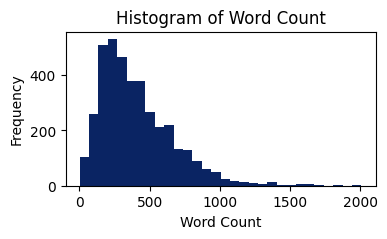

In [7]:
df['transcription_word_count'] = df['transcription'].apply(lambda x:len(x.split()))

plt.figure(figsize=(4, 2))
plt.hist(df['transcription_word_count'], bins=30, color='#0A2463', edgecolor='none')
plt.title('Histogram of Word Count')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

Note that not all encounters classified as OB/GYN are about pregnancy. For example, some are for mammograms.

In [8]:
df[(df['medical_specialty'] == ' Obstetrics / Gynecology') & df['keywords'].str.contains('mammogram')].head(2)

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords,transcription_word_count
2552,2552,Consultation for an ASCUS Pap smear.,Obstetrics / Gynecology,OB/GYN Consultation - 3,Pap smear in November 2006 showed atypical squ...,"obstetrics / gynecology, lmp, ascus, pap smear...",537
2607,2607,"Mammogram, bilateral full-field digital mammo...",Obstetrics / Gynecology,Full-Field Digital Mammogram (FFDM) - 2,"EXAM: , Screening full-field digital mammogram...","obstetrics / gynecology, digital mammography, ...",251


Similarly, not all encounters about pregnancy are classified as OB/GYN. For example, some are classified as surgeries.

In [9]:
df[(df['medical_specialty'] == ' Surgery') & df['keywords'].str.contains('pregnancy')].head(2)

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords,transcription_word_count
206,206,Vacuum-assisted vaginal delivery of a third-d...,Surgery,Vaginal Delivery - Vacuum-Assisted,"PREOPERATIVE DIAGNOSES,1. A 40 weeks 6 days i...","surgery, intrauterine pregnancy, non-reassurin...",620
310,310,"Missed abortion. Suction, dilation, and cure...",Surgery,"Suction, Dilation, & Curettage","PREOPERATIVE DIAGNOSIS: , Missed abortion.,POS...","surgery, missed abortion, intrauterine pregnan...",345


There is potential business value in being able to classify future notes as being about pregnancy or not. To do this, we will train a large language model to predict whether a clinical note discusses a patient's pregnancy.

Use keywords to construct a label for training. Note, there is severe class imbalance in the label.

In [10]:
columns = ['description', 'sample_name', 'keywords']
df['pregnancy'] = df.apply(lambda row: 1 if any(('fetal' in str(row[col]).lower() or
                                                 'fetus' in str(row[col]).lower() or
                                                 'pregnancy' in str(row[col]).lower() or
                                                 'pregnant' in str(row[col]).lower() or
                                                 'c-section' in str(row[col]).lower() or
                                                 'vaginal delivery' in str(row[col]).lower() or
                                                 'abortion' in str(row[col]).lower() or
                                                 'gestation' in str(row[col]).lower() or
                                                 'prenatal' in str(row[col]).lower() or
                                                 'postpartum' in str(row[col]).lower() or
                                                 'childbirth' in str(row[col]).lower() or
                                                 'child birth' in str(row[col]).lower() or
                                                 'placenta' in str(row[col]).lower() or
                                                 'eclampsia' in str(row[col]).lower()) for col in columns) else 0, axis=1)
df['pregnancy'].value_counts(dropna=False)

pregnancy
0    3778
1     120
Name: count, dtype: int64

Address class imbalance by upsampling the minority class and downsampling the majority class.

In [11]:
class_0 = df[df['pregnancy'] == 0]
class_1 = df[df['pregnancy'] == 1]

upsampled_class_1 = class_1.sample(n=500, replace=True, random_state=42)
downsampled_class_0 = class_0.sample(n=1000, random_state=42)
df = pd.concat([downsampled_class_0, upsampled_class_1]).sample(frac=1, random_state=42).reset_index(drop=True)
df['pregnancy'].value_counts(dropna=False)

pregnancy
0    1000
1     500
Name: count, dtype: int64

Add some synthetic data to further augment the minority class. The following fake notes were generated by ChatGPT 3.5 using the prompt "Non-randomly generate 50 brief fake clinical notes, each no more than 20 words, about patients who had a pregnancy.  Organize them in a pandas dataframe with two columns: 'transcription' (where you put the fake note as a string), and 'pregnancy' (which should take the value 1)."

In [12]:
synthetic_data = [
    "Patient had a healthy full-term pregnancy.",
    "Prenatal care included regular check-ups and ultrasounds.",
    "Mother and baby both in good health post-delivery.",
    "Patient experienced normal pregnancy symptoms.",
    "Delivery went smoothly with no complications.",
    "Mother and newborn are doing well after childbirth.",
    "Routine prenatal tests were conducted.",
    "Patient followed recommended dietary guidelines during pregnancy.",
    "Postpartum check-up scheduled for next month.",
    "Congratulations! A new addition to the family.",
    "Antenatal classes helped prepare for childbirth.",
    "Patient had a positive pregnancy test result.",
    "Maternal health monitored throughout the gestation period.",
    "Baby's first cry brought joy to the delivery room.",
    "Patient is now a proud parent after successful pregnancy.",
    "No complications reported during the labor and delivery.",
    "Patient experienced typical pregnancy cravings.",
    "Regular fetal monitoring ensured a healthy pregnancy.",
    "Pregnancy was confirmed through ultrasound imaging.",
    "Newborn passed all initial health assessments.",
    "Patient received prenatal vitamins and supplements.",
    "Postpartum support provided for the new mother.",
    "Patient expressed excitement and joy about impending parenthood.",
    "Delivery room staff provided compassionate care.",
    "Maternal and infant bonding emphasized during postpartum care.",
    "Patient opted for a natural childbirth experience.",
    "Ultrasound revealed a healthy fetal heartbeat.",
    "Patient attended prenatal education classes.",
    "Baby's first milestones celebrated by the family.",
    "Pregnancy journey documented with regular medical check-ups.",
    "Patient reported normal weight gain during pregnancy.",
    "Obstetrician provided guidance on prenatal exercises.",
    "Mother and baby shared a special moment during skin-to-skin contact.",
    "Patient chose a personalized birthing plan.",
    "Pregnancy was a positive and transformative experience.",
    "Delivery room team ensured a comfortable birthing environment.",
    "Baby's first vaccinations scheduled for the coming weeks.",
    "Patient's support system played a crucial role during pregnancy.",
    "Pregnancy-related discomforts were managed with care.",
    "Motherhood journey officially began with a healthy delivery.",
    "Patient expressed gratitude for the exceptional prenatal care.",
    "Newborn's first pediatrician appointment scheduled.",
    "Patient adhered to recommended prenatal vaccination schedule.",
    "Family eagerly awaited the arrival of the newest member.",
    "Maternity ward staff provided nurturing care postpartum.",
    "Pregnancy announcement brought joy to family and friends.",
    "Patient documented pregnancy milestones in a journal.",
    "Postpartum recovery progressing as expected.",
]

synthetic_data = pd.DataFrame({'transcription': synthetic_data, 'pregnancy': 1})
df = pd.concat([df, synthetic_data], axis=0)
df['pregnancy'].value_counts(dropna=False)


pregnancy
0    1000
1     548
Name: count, dtype: int64

Add some additional synthetic data containing common-sense examples for the model to learn from.

In [13]:
synthetic_data = {
    'This note is about pregnancy':1,
    'This note is not about pregnancy':0,
    'This note does not discuss pregnancy':0,
    'This note has nothing to do with pregnancy':0,
    'This note is about topics other than pregnancy':0,
    'Pregnancy is not mentioned in this note':0,
    'Pregnancy is not the topic of this note':0,
    'Discussion of a chronic condition unrelated to pregnancy':0,
    'A pregnant woman with a pre-existing medical condition is being monitored':1,
    'A woman with a pre-existing medical condition is being monitored':0,
    'The patient is pregnant':1,
    'The patient is breastfeeding':1,
    'She is in labor and having contractions':1,
    'The patient is 8 months pregnant':1,
    'She has concerns about this pregnancy':1,
    'The patient has high cholesterol':0,
    'The patient has hypertension':0,
    'The patient has a broken arm':0,
    'The patient has high cholesterol and no other health conditions':0,
    'The patient has hypertension and no other health conditions':0,
    'The patient has a broken arm and no other health conditions':0,
    'The patient has high cholesterol and is pregnant':1,
    'The patient has hypertension and is pregnant':1,
    'The patient has a broken arm and is pregnant':1,
    'The patient presented with a fever and nausea':0,
    'The patient presented with a fever and nausea. They are pregnant':1,
    'The patient is on several medications':0,
    'The patient is on several medications. They are pregnant':1,
    'The patient had a c-section':1,
    'The patient had a vaginal delivery':1,
    'She had similar episodes in prior pregnancies':1,
    'Vaginal bleeding during pregnancy':1,
    'Mom is taking prenatal vitamins':1,
    'This visit is to provide prenatal care':1,
    'The pregnancy test was positive.':1,
    'She has pre-eclampsia.':1
}

synthetic_data = pd.DataFrame(list(synthetic_data.items()), columns=['transcription', 'pregnancy'])
df = pd.concat([df, synthetic_data], axis=0)
df['pregnancy'].value_counts(dropna=False)

pregnancy
0    1016
1     568
Name: count, dtype: int64

## Fine Tune a Large Language Model

Useful resources:
- https://towardsdatascience.com/fine-tuning-pretrained-nlp-models-with-huggingfaces-trainer-6326a4456e7b
- https://www.youtube.com/watch?app=desktop&v=4nNbg4bWDrQ
- https://medium.com/@rakeshrajpurohit/customized-evaluation-metrics-with-hugging-face-trainer-3ff00d936f99
- https://huggingface.co/docs/transformers/training

Split the data into training, validation, and test sets. We will use 10% of the data for validation and 10% of the data for testing. Setting the random state ensures reproducability.

In [14]:
X = list(df['transcription'])
y = list(df['pregnancy'])

train_size = 0.8
validation_size = 0.1
test_size = 1 - train_size - validation_size

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=1 - train_size, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=validation_size / (validation_size + test_size), stratify=y_temp, random_state=42)

print(f'Training set size: {len(X_train)}')
print(f'Validation set size: {len(X_valid)}')
print(f'Test set size: {len(X_test)}')

Training set size: 1267
Validation set size: 158
Test set size: 159


Load the tokenizer and model. BERT is a widely used model that was trained on a large amount of English-language data. The Bio+Clinical BERT model was built on BERT and subsequently trained on a database of electronic health records. More information can be found at https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT.

It is typical to see the message "Some weights of [the model] were not initialized..." because the weights for the final classification layer are task-specific and need to be initialized for the use case.

In [15]:
model_name = 'emilyalsentzer/Bio_ClinicalBERT'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


If available, move the model to a GPU. It will run much faster than on a CPU.

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [17]:
model.to(device);

Tokenize the data. Tokenization refers to breaking text into small units for analysis in natural langauge processing. The BERT tokenizer uses subword tokenization, and the maximum number of tokens that BERT can take is 512.

In [18]:
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_valid_tokenized = tokenizer(X_valid, padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=512)

Define a custom PyTorch dataset class to generate datasets designed to handle tokenized and encoded data. While tokenization refers to breaking text into small components, encoding refers to converting tokens into numbers that can be processed by the algorithm.

The transformers trainer requires a `torch.utils.data.Dataset` class:
- `__init__` method: initializes the dataset with encoded input data. The default labels parameter is set to `None` so we can make predictions on new unlabeled data.
- `__getitem__` method: given an index, retrieves the corresponding data for that index and converts it into a PyTorch tensor.
- `__len__` method: returns the total number of samples in the dataset.

In [19]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

Use the custom dataset class to create datasets for the training, validation, and test sets.

In [20]:
train_dataset = CustomDataset(X_train_tokenized, y_train)
valid_dataset = CustomDataset(X_valid_tokenized, y_valid)
test_dataset = CustomDataset(X_test_tokenized) # Leave the test set unlabeled

Create a function to compute and report metrics for evaluating model performance during training. The `compute_metrics` function takes a tuple containing predictions (class probabilities) and labels, and keeps the most likely predicted class. It then calculates model performance metrics appropriate for classification tasks, and stores the results in a dictionary.

In [21]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average='weighted')
    precision = precision_score(y_true=labels, y_pred=pred, average='weighted')
    f1 = f1_score(y_true=labels, y_pred=pred, average='weighted')
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1}

Create an instsance of the `TrainingArguments` class to define model hyperparameters. There are many additional hyperparameters and options that could be used.

In [22]:
args = TrainingArguments(
    output_dir='output',
    evaluation_strategy='steps',
    eval_steps=250,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    seed=42,
    load_best_model_at_end=True,
    optim="adamw_torch",
    learning_rate=1e-5,
    weight_decay=1e-4,
    warmup_steps=500,
    lr_scheduler_type='cosine',
)

Configure and initialize a `Trainer` object.

In [23]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

Run the `trainer` to fine-tune the model. This takes some time.

In [24]:
trainer.train()

  0%|          | 0/240 [00:00<?, ?it/s]

{'train_runtime': 86.9186, 'train_samples_per_second': 43.731, 'train_steps_per_second': 2.761, 'train_loss': 0.4542692184448242, 'epoch': 3.0}


TrainOutput(global_step=240, training_loss=0.4542692184448242, metrics={'train_runtime': 86.9186, 'train_samples_per_second': 43.731, 'train_steps_per_second': 2.761, 'train_loss': 0.4542692184448242, 'epoch': 3.0})

Review the model performance metrics.

In [25]:
train_metrics = trainer.evaluate(train_dataset)
valid_metrics = trainer.evaluate(valid_dataset)
train_metrics_df = pd.DataFrame({"Training": train_metrics})
valid_metrics_df = pd.DataFrame({"Validation": valid_metrics})
metrics_df = pd.concat([train_metrics_df.round(2), valid_metrics_df.round(2)], axis=1)
metrics_df

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

,Training,Validation
epoch,3.00,3.00
eval_accuracy,0.99,1.00
eval_f1,0.99,1.00
eval_loss,0.06,0.04
eval_precision,0.99,1.00
eval_recall,0.99,1.00
eval_runtime,9.88,1.23
eval_samples_per_second,128.25,128.82
eval_steps_per_second,8.10,8.15


Save the model and tokenizer.

In [26]:
model_path = 'identifying_pregnancy_clinical_notes_model'
tokenizer.save_pretrained(model_path)
trainer.save_model(model_path)

## Make Predictions on the Test Set

We already tokenized the test set and created a `CustomDataset` called `test_dataset`, so the data is ready to be modeled.

Load the trained model.

In [27]:
model_path = 'identifying_pregnancy_clinical_notes_model'
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

Define the test trainer. Since we're just making predictions, we will use the default configurations.

In [28]:
test_trainer = Trainer(model)

Make predictions. The raw result is an array containing vectors with one score for each of the possible assigned classes.

In [29]:
raw_pred, _, _ = test_trainer.predict(test_dataset)

  0%|          | 0/20 [00:00<?, ?it/s]

Compare the actuals from the test set against the predictions. We will use the `compute_metrics` function that we defined for model fine-tuning.

In [30]:
y_pred = np.argmax(raw_pred, axis=1)

confusion_matrix = pd.crosstab(pd.Series(y_pred, name='y_pred'), pd.Series(y_test, name='y_test'))
confusion_matrix

y_test,0,1
y_pred,,
0,98,0
1,4,57


In [31]:
test_tuple = (raw_pred, np.array(y_test))

metrics = compute_metrics(test_tuple)
metrics_df = pd.DataFrame(metrics, index=[0])
metrics_df = metrics_df.T.reset_index()
metrics_df.columns = ['Metric', 'Value']
metrics_df

,Metric,Value
0,accuracy,0.974843
1,precision,0.976492
2,recall,0.974843
3,f1,0.975018


## Develop an App

We will use Gradio to let users input text and get predictions from the model. Gradio can be hosted on HuggingFace spaces.

Useful resources:
- https://www.gradio.app/guides/controlling-layout
- https://www.youtube.com/watch?v=bN9WTxzLBRE
- https://www.youtube.com/watch?v=dzS97S698H0

In [ ]:
model_path = 'identifying_pregnancy_clinical_notes_model'
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

def predict(text):

    inputs = tokenizer(text, return_tensors="pt")
    num_tokens = inputs['input_ids'].size(1)

    if num_tokens <= 512:

        outputs = model(**inputs)

        predicted_class_id = torch.argmax(outputs.logits).item()
        probability_of_predicted_class = round(torch.nn.functional.softmax(outputs.logits, dim=1)[0, predicted_class_id].item(),2)

        if (predicted_class_id == 0) & (probability_of_predicted_class >= 0.5):
            predicted_class_label = "No, the note does not discuss the patient's pregnancy based on the model's assessment."
        elif (predicted_class_id == 1) & (probability_of_predicted_class >= 0.8):
            predicted_class_label = "Yes, the note discusses the patient's pregnancy based on the model's assessment."
        else:
            predicted_class_label = "The model was unable to determine with high certainty whether or not the note discusses the patient's pregnancy. Please provide additional text or a different note."
        
        return predicted_class_label
    
    else:
        
        error_message = 'Unfortunately the model is limited in how much text it can process at once. Please enter a shorter note.'

        return error_message

with gr.Blocks() as interface:
    gr.Markdown("<h1 align='center'>Identifying Pregnancy in Clinical Notes</h1>")
    gr.Markdown("<p align='center'>Use this app to classify a clinical note as discussing or not discussing the patient's pregnancy.</p>")
    with gr.Row():
        with gr.Column():
            inputs = gr.Textbox(label='Input a clinical note here:', lines=4)
            button = gr.Button('Assess Note')
            gr.Examples(['The patient is pregnant.', 'She has high cholesterol and hypertension.', 'Normal vaginal delivery.', 'Fetus development normal.', 'Presented with nausea.', 'Broken arm and leg.'], inputs)
        with gr.Column():
            outputs=gr.Textbox(label="Does the note discuss the patient's pregnancy?", lines=4)
            button.click(fn=predict, inputs=inputs, outputs=outputs, queue=False)
    gr.Markdown("<p align='center'>Model fine-tuned from <a href='https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT' target='_blank'> Bio+ClinicalBERT </a>.</p>")

interface.launch()

Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.


Exception in thread Thread-42:
Traceback (most recent call last):
  File "/Users/ellie/Library/Python/3.9/lib/python/site-packages/httpcore/_exceptions.py", line 10, in map_exceptions
    yield
  File "/Users/ellie/Library/Python/3.9/lib/python/site-packages/httpcore/_backends/sync.py", line 168, in start_tls
    raise exc
  File "/Users/ellie/Library/Python/3.9/lib/python/site-packages/httpcore/_backends/sync.py", line 163, in start_tls
    sock = ssl_context.wrap_socket(
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/ssl.py", line 500, in wrap_socket
    return self.sslsocket_class._create(
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/ssl.py", line 1040, in _create
    self.do_handshake()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
